In [0]:
!pip install catboost
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import tensorflow as tf
from catboost import Pool, CatBoostClassifier, cv
from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,roc_curve,auc
import keras
import seaborn as sns
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb


In [0]:
df_train = pd.read_csv('drive/My Drive/KOS/credit_card_default_train.csv')
df_test = pd.read_csv('drive/My Drive/KOS/credit_card_default_test.csv')

df_train.drop('Client_ID',axis=1,inplace=True)
df_test.drop('Client_ID',axis=1,inplace=True)

#df_train['DUE_AMT_JULY'] = df_train['DUE_AMT_JULY'] + df_train['DUE_AMT_AUG'] + df_train['DUE_AMT_SEP'] + df_train['DUE_AMT_OCT'] + df_train['DUE_AMT_NOV'] + df_train['DUE_AMT_DEC'] - (df_train['PAID_AMT_JULY']+ df_train['PAID_AMT_AUG'] + df_train['PAID_AMT_SEP'] + df_train['PAID_AMT_OCT'] + df_train['PAID_AMT_NOV'] + df_train['PAID_AMT_DEC'])

In [5]:
df_train['DUE_AMT_JULY'] = df_train['DUE_AMT_JULY'] + df_train['DUE_AMT_AUG'] + df_train['DUE_AMT_SEP'] + df_train['DUE_AMT_OCT'] + df_train['DUE_AMT_NOV'] + df_train['DUE_AMT_DEC'] - (df_train['PAID_AMT_JULY']+ df_train['PAID_AMT_AUG'] + df_train['PAID_AMT_SEP'] + df_train['PAID_AMT_OCT'] + df_train['PAID_AMT_NOV'] + df_train['PAID_AMT_DEC'])
df_test['DUE_AMT_JULY'] = df_test['DUE_AMT_JULY'] + df_test['DUE_AMT_AUG'] + df_test['DUE_AMT_SEP'] + df_test['DUE_AMT_OCT'] + df_test['DUE_AMT_NOV'] + df_test['DUE_AMT_DEC'] - (df_test['PAID_AMT_JULY']+ df_test['PAID_AMT_AUG'] + df_test['PAID_AMT_SEP'] + df_test['PAID_AMT_OCT'] + df_test['PAID_AMT_NOV'] + df_test['PAID_AMT_DEC'])
#df_train['PAID_AMT_JULY'] = df_train['PAID_AMT_JULY']+ df_train['PAID_AMT_AUG'] + df_train['PAID_AMT_SEP'] + df_train['PAID_AMT_OCT'] + df_train['PAID_AMT_NOV'] + df_train['PAID_AMT_DEC']
#df_train['DUE_AMT_AUG'] = df_train['DUE_AMT_AUG'] - df_train['PAID_AMT_AUG']
#df_train['DUE_AMT_SEP'] = df_train['DUE_AMT_SEP'] - df_train['PAID_AMT_SEP']
#df_train['DUE_AMT_OCT'] = df_train['DUE_AMT_OCT'] - df_train['PAID_AMT_OCT']
#df_train['DUE_AMT_NOV'] = df_train['DUE_AMT_NOV'] - df_train['PAID_AMT_NOV']
#df_train['DUE_AMT_DEC'] = df_train['DUE_AMT_DEC'] - df_train['PAID_AMT_DEC']
df_train.head()

,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,NEXT_MONTH_DEFAULT
0,1M,M,Graduate,Other,31-45,-1,-1,-1,-1,-1,-1,-548947,3389,6004,39418,162772,-13982,3437,6004,39418,162772,0,538165,0
1,1M,F,High School,Other,Less than 30,0,-1,-1,-1,-1,0,424081,151818,26948,43530,80811,124590,151818,46200,43530,80811,942,33666,0
2,100K,F,High School,Single,31-45,4,3,2,2,-2,-2,48240,16082,15477,0,0,0,0,0,0,0,0,0,1
3,200K,F,Graduate,Single,31-45,2,0,0,0,0,0,554872,92848,95193,97309,100353,102740,3855,3890,3696,4620,4049,3918,1
4,1M,F,Graduate,Other,31-45,2,2,0,0,0,0,2525320,419466,429785,435354,445271,453899,0,20790,16170,17325,16401,17325,0


In [0]:
def age_enc(df):  
  for i,val in enumerate(df['AGE']):
    if (val == "31-45"):
      df['AGE'][i] = 1
    elif (val == 'Less than 30'):
      df['AGE'][i] = 0
    elif (val == "46-65"):
      df['AGE'][i] = 2
    elif (val == 'More than 65'):
      df['AGE'][i] = 3

def balance (df):
  for i,val in enumerate(df['Balance_Limit_V1']):
    if (val == "2.5M"):
      df['Balance_Limit_V1'][i] = 2500000
    elif (val == '1.5M'):
      df['Balance_Limit_V1'][i] = 1500000
    elif (val == "1M"):
      df['Balance_Limit_V1'][i] = 1000000
    elif (val == '400K'):
      df['Balance_Limit_V1'][i] = 400000
    elif (val == '300K'):
      df['Balance_Limit_V1'][i] = 300000
    elif (val == '200K'):
      df['Balance_Limit_V1'][i] = 200000
    elif (val == '100K'):
      df['Balance_Limit_V1'][i] = 100000
    elif (val == ' 500K'):
      df['Balance_Limit_V1'][i] = 500000
  df['Balance_Limit_V1'] = pd.to_numeric(df['Balance_Limit_V1'])

def encode_cat(df):
  fields = ['Gender','EDUCATION_STATUS','MARITAL_STATUS']
  for field in fields:
    encoder = LabelEncoder()
    encoded = df[field]
    df[field] = encoder.fit_transform(encoded)
    encoding = {}

    for idx,value in enumerate(encoder.classes_):
        encoding[idx]=value
        
    print("%s: "%field,encoding)

def normalize(df):
  col_to_norm = ['DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT',
       'DUE_AMT_NOV', 'DUE_AMT_DEC', 'PAID_AMT_JULY', 'PAID_AMT_AUG',
       'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']
  df[col_to_norm] = df[col_to_norm].apply(lambda x : (x-np.mean(x))/np.std(x))

In [7]:
age_enc(df_train)
#balance(df_train)
encode_cat(df_train)
normalize(df_train)

age_enc(df_test)
#balance(df_test)
encode_cat(df_test)
normalize(df_test)

Gender:  {0: 'F', 1: 'M'}
EDUCATION_STATUS:  {0: 'Graduate', 1: 'High School', 2: 'Other'}
MARITAL_STATUS:  {0: 'Other', 1: 'Single'}
Gender:  {0: 'F', 1: 'M'}
EDUCATION_STATUS:  {0: 'Graduate', 1: 'High School', 2: 'Other'}
MARITAL_STATUS:  {0: 'Other', 1: 'Single'}


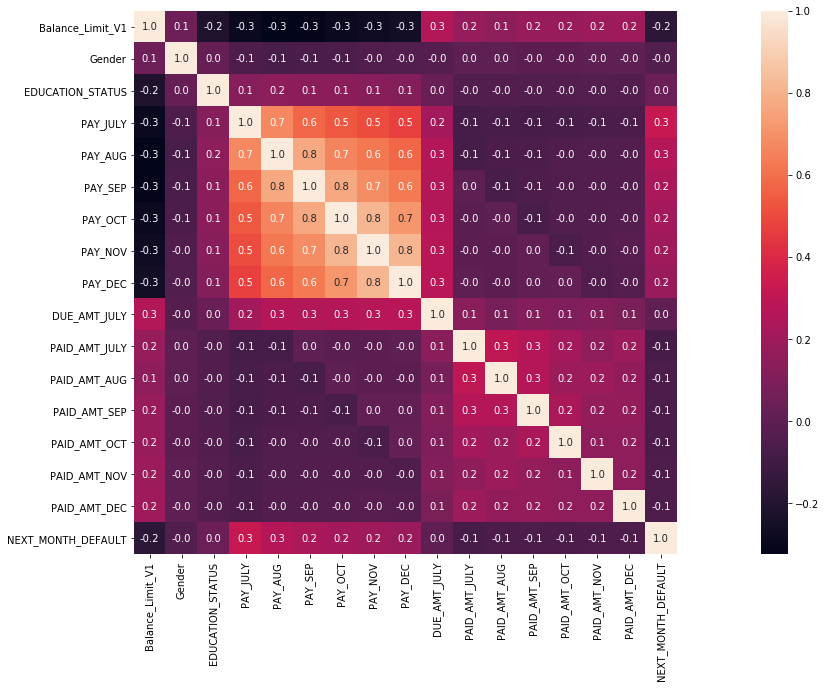

In [13]:
correlation = df_train.corr()
plt.subplots(figsize=(30,10))
sns.heatmap( correlation, square=True, annot=True, fmt=".1f" )

In [8]:
train_test_data = [df_train, df_test]
balance_limit_mapping = {"100K": 0, "200K": 1, "300K": 2, "400K": 3, " 500K":4, "1M":5, "1.5M": 6, "2.5M" :7}
for dataset in train_test_data:
    dataset['Balance_Limit_V1'] = dataset['Balance_Limit_V1'].map(balance_limit_mapping)
#df_train.drop('EDUCATION_STATUS', axis=1, inplace=True)
df_train.drop('MARITAL_STATUS', axis=1, inplace=True)
df_test.drop('MARITAL_STATUS', axis=1, inplace=True)
#df_train.drop('AGE', axis=1, inplace=True)
#df_train.drop('Gender', axis=1, inplace=True)
#df_train.drop('DUE_AMT_JULY', axis=1, inplace=True)
df_train.drop('DUE_AMT_AUG', axis=1, inplace=True)
df_train.drop('DUE_AMT_SEP', axis=1, inplace=True)
df_train.drop('DUE_AMT_OCT', axis=1, inplace=True)
df_train.drop('DUE_AMT_NOV', axis=1, inplace=True)
df_train.drop('DUE_AMT_DEC', axis=1, inplace=True)
df_test.drop('DUE_AMT_AUG', axis=1, inplace=True)
df_test.drop('DUE_AMT_SEP', axis=1, inplace=True)
df_test.drop('DUE_AMT_OCT', axis=1, inplace=True)
df_test.drop('DUE_AMT_NOV', axis=1, inplace=True)
df_test.drop('DUE_AMT_DEC', axis=1, inplace=True)
#df_train.drop('PAID_AMT_JULY', axis=1, inplace=True)
#df_train.drop('PAID_AMT_AUG', axis=1, inplace=True)
#df_train.drop('PAID_AMT_SEP', axis=1, inplace=True)
#df_train.drop('PAID_AMT_OCT', axis=1, inplace=True)
#df_train.drop('PAID_AMT_NOV', axis=1, inplace=True)
#df_train.drop('PAID_AMT_DEC', axis=1, inplace=True)
df_train.head()
df_test.head()

,Balance_Limit_V1,Gender,EDUCATION_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC
0,4,1,2,1,0,0,0,0,0,0,0.845660,0.045412,-0.002844,4.511344,1.179452,0.203018,0.055113
1,1,0,2,1,0,0,0,0,0,0,-0.007184,-0.251679,-0.242606,-0.198760,-0.173004,-0.190318,-0.180657
2,3,1,2,0,-1,-1,2,0,0,-1,-0.672996,-0.156946,-0.345254,-0.237559,-0.301502,-0.262225,0.817512
3,6,1,0,1,1,-1,-1,-2,-2,-2,-0.662563,-0.191419,-0.190961,-0.294283,-0.301502,-0.334131,-0.310779
4,0,0,1,0,0,0,-2,-2,-2,-2,-0.558062,-0.363782,-0.345254,-0.294283,-0.301502,-0.334131,-0.310779


In [0]:
X = df_train.iloc[:,:-1].values
y = df_train.iloc[:,-1].values
df_test.head()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [10]:
model = CatBoostClassifier(eval_metric='Accuracy',colsample_bylevel=0.5,max_depth=8,n_estimators=500,learning_rate=0.01,use_best_model=True,random_seed=42)
model.fit(X_train,y_train,eval_set=(X_test,y_test))
y_pred = model.predict(X_test)
#Making the Confusion Matrix
cm = confusion_matrix(y_test, (y_pred>0.5))
print(colored('The Confusion Matrix is: ', 'red'),'\n', cm)
# Calculate the accuracy on test set
predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
print(colored('The Accuracy on Test Set is: ', 'blue'), colored(predict_accuracy_on_test_set, 'blue'))

0:	learn: 0.8191667	test: 0.8243750	best: 0.8243750 (0)	total: 67.5ms	remaining: 33.7s
1:	learn: 0.8204687	test: 0.8250000	best: 0.8250000 (1)	total: 84.5ms	remaining: 21s
2:	learn: 0.8208854	test: 0.8260417	best: 0.8260417 (2)	total: 101ms	remaining: 16.8s
3:	learn: 0.8207813	test: 0.8268750	best: 0.8268750 (3)	total: 117ms	remaining: 14.5s
4:	learn: 0.8210417	test: 0.8264583	best: 0.8268750 (3)	total: 135ms	remaining: 13.3s
5:	learn: 0.8201563	test: 0.8262500	best: 0.8268750 (3)	total: 161ms	remaining: 13.3s
6:	learn: 0.8207813	test: 0.8260417	best: 0.8268750 (3)	total: 179ms	remaining: 12.6s
7:	learn: 0.8207292	test: 0.8260417	best: 0.8268750 (3)	total: 196ms	remaining: 12s
8:	learn: 0.8212500	test: 0.8268750	best: 0.8268750 (3)	total: 212ms	remaining: 11.5s
9:	learn: 0.8208854	test: 0.8262500	best: 0.8268750 (3)	total: 228ms	remaining: 11.2s
10:	learn: 0.8213542	test: 0.8262500	best: 0.8268750 (3)	total: 248ms	remaining: 11s
11:	learn: 0.8210417	test: 0.8260417	best: 0.8268750 (3)	

In [11]:
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model2 = pd.DataFrame([['CAT Boost', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

model2

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,CAT Boost,0.830833,0.718133,0.379147,0.496278,0.668612


In [0]:
y_pred = model.predict(df_test)
submission = pd.read_csv('drive/My Drive/KOS/credit_card_default_test.csv')
submission.loc[:,'NEXT_MONTH_DEFAULT'] = np.uint8(y_pred)
submission.to_csv("sub2.csv",index=False)